In [7]:
import json
import pandas as pd
pd.set_option('display.precision', 2)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob

In [8]:
def get_dir_info(dir):
    args_path = os.path.join(dir, 'args.json')
    with open(args_path, 'r') as f:
        args = json.load(f)
    model = args.get('model')
    args['attacker_llm_model'] = args.get('attacker_llm_model') if args.get('attacker_llm_model') is not None else model
    args['defender_llm_model'] = args.get('defender_llm_model') if args.get('defender_llm_model') is not None else model
    return args

In [9]:
# get best percentage for each model
def get_best_percentage(directory, iterations=10):
    # get all *-improvement-history.json files in the model directory
    path = f'{directory}/*-improvement_history.jsonl'
    improvement_files = glob.glob(path)
    # get the best percentage for each file
    best_percentages = []
    for file in improvement_files:
        with open(file, 'r') as f:
            improvement_history = pd.read_json(file, lines=True)
            best_percentages.append(improvement_history[improvement_history['attempt'] < iterations]['percent'].max())
    return best_percentages

In [5]:
# iterate over all directories in 'final-results'
models = [dir for dir in os.listdir('final-results')]
print(models)

iteration_df = []
# create heatmap by generating a matrix of the best percentage for each model
for attacker_model in models:
    for eval_model in models:
        if attacker_model == "gpt-4o" or eval_model == "gpt-4o":
            print("skipping gpt-4o -- not implemented")
            continue

        percentages = []
        if attacker_model == eval_model:
            percentages = get_best_percentage(f"final-results/{eval_model}/attack")
        
        else:
            percentages = get_best_percentage(f"final-results/{eval_model}/transferability/{attacker_model}")
        
        if len(percentages) == 0:
            continue

        attack_success_rate = np.mean(percentages)

        # add to dataframe
        # The issue is that when you pass a dictionary of scalars to pd.DataFrame, pandas doesn't know how many rows to create.
        # Instead, wrap each value in a list so pandas creates a single-row DataFrame.
        iteration_df.append({'attacker_model': attacker_model, 'eval_model': eval_model, 'attack_success_rate': attack_success_rate})
        # break
    # break
        
iteration_df = pd.DataFrame(iteration_df)
iteration_df
        
    


['deepseek-chat', 'gpt-oss', 'qwen2.5', 'gpt-4o', 'llama3.1', 'gemini-2.5-flash-lite']
skipping gpt-4o -- not implemented
skipping gpt-4o -- not implemented
skipping gpt-4o -- not implemented
skipping gpt-4o -- not implemented
skipping gpt-4o -- not implemented
skipping gpt-4o -- not implemented
skipping gpt-4o -- not implemented
skipping gpt-4o -- not implemented
skipping gpt-4o -- not implemented
skipping gpt-4o -- not implemented
skipping gpt-4o -- not implemented


,attacker_model,eval_model,attack_success_rate
0,deepseek-chat,deepseek-chat,81.62
1,deepseek-chat,gpt-oss,45.88
2,deepseek-chat,qwen2.5,39.82
3,deepseek-chat,llama3.1,35.32
4,deepseek-chat,gemini-2.5-flash-lite,28.90
5,gpt-oss,deepseek-chat,71.04
6,gpt-oss,gpt-oss,73.62
7,gpt-oss,qwen2.5,55.36
8,gpt-oss,llama3.1,34.98
9,gpt-oss,gemini-2.5-flash-lite,41.32


In [6]:
# Pivot the data to create a matrix format
heatmap_data = iteration_df.pivot(index='eval_model', columns='attacker_model', values='attack_success_rate')

# Create the heatmap
plt.figure(figsize=(10, 8), dpi=1200)
sns.heatmap(heatmap_data, 
            annot=True,           # Show values in cells
            fmt='.1f',            # Format numbers to 1 decimal place
            cmap='RdYlBu_r',      # Color scheme (red-yellow-blue reversed)
            cbar_kws={'label': 'TSR'}, # Color bar label
            square=True,          # Make cells square
            linewidths=0.5,       # Add grid lines
            center=40,
            linecolor='white',
            vmin=0,
            vmax=100,
            annot_kws={'size': 14})   # font size

plt.title('Attack Transferability Heatmap', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Attacker Model', fontsize=12, fontweight='bold')
plt.ylabel('Evaluation Model', fontsize=12, fontweight='bold')

# Rotate labels if they're long
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

In [26]:

# iterate over all directories in 'final-results'
models = [dir for dir in os.listdir('final-results') if dir != 'gpt-4o']
print(models)

iteration_df = []
# read attack, baseline-attack, and baseline-defended
for model in models:
    # read attack, baseline-attack, and baseline-defended, and defended
    for folder in ['no-attack','attack', 'baseline-attack', 'baseline-defended', 'defended', 'attack-defended']:
        
        percentages = []
        # read all *-improvement-history.jsonl files in the model directory
        if folder == 'no-attack':
            percentages = get_best_percentage(f"final-results/{model}/attack", iterations=1)
        else:
            percentages = get_best_percentage(f"final-results/{model}/{folder}")
        if not percentages or len(percentages) == 0:
            continue
        attack_success_rate = np.mean(percentages)

        iteration_df.append({'model': model, 'setting': folder, 'attack_success_rate': attack_success_rate})

        
iteration_df = pd.DataFrame(iteration_df)
iteration_df.pivot(index='setting', columns='model', values='attack_success_rate')


['deepseek-chat', 'gpt-oss', 'qwen2.5', 'llama3.1', 'gemini-2.5-flash-lite', 'grok-3-mini']


model,deepseek-chat,gemini-2.5-flash-lite,gpt-oss,grok-3-mini,llama3.1,qwen2.5
setting,,,,,,
attack,81.62,48.66,73.62,50.74,33.96,45.92
attack-defended,59.74,37.50,67.96,NaN,34.42,46.74
baseline-attack,68.66,56.10,76.44,89.46,38.12,61.26
baseline-defended,30.20,21.32,37.50,22.74,20.44,32.76
defended,48.64,30.16,63.30,32.78,27.24,34.30
no-attack,20.16,18.86,18.96,19.94,19.84,19.90


In [19]:
def _make_pretty_latex(df, column_format, escape=False):
    """
    A helper function to convert a DataFrame to a grid-style LaTeX table.
    
    Note: For this to render correctly, do NOT use the \\usepackage{booktabs}
    in your LaTeX document, as it can interfere with vertical lines.
    """
    # remove setting row
    df.index.name = None
    df.columns.name = None
    # Generate LaTeX with specified column format for vertical lines
    latex_str = df.to_latex(column_format=column_format, escape=escape)
    
    # Replace booktabs rules with standard hlines for a grid look
    latex_str = latex_str.replace('\\toprule', '\\hline')
    latex_str = latex_str.replace('\\midrule', '\\hline')
    latex_str = latex_str.replace('\\bottomrule', '\\hline')
    
    return latex_str

def create_attack_latex_table(df, row_order, column_rename_map=None, index_rename_map=None):
    """Creates a pretty LaTeX table for attack scenarios."""
    table_df = df.loc[row_order].copy()

    if column_rename_map:
        table_df.rename(columns=column_rename_map, inplace=True)
    if index_rename_map:
        table_df.rename(index=index_rename_map, inplace=True)
    
    if index_rename_map:
        renamed_order = [index_rename_map.get(row, row) for row in row_order]
        table_df = table_df.reindex(renamed_order)
    
    for model in table_df.columns:
        table_df[model] = table_df[model].apply(lambda x: f"{x:.2f}")

    # Define column format: |l|r|r|r| (left-aligned index, right-aligned data)
    col_format = '|l' + '|r' * len(table_df.columns) + '|'
    
    return _make_pretty_latex(table_df, col_format)

def create_defended_latex_table(df, row_order, column_rename_map=None, index_rename_map=None):
    """Creates a pretty LaTeX table for defended scenarios with deltas."""
    table_df = df.loc[row_order].copy()
    
    for model in table_df.columns:
        attack_rate = df.loc['attack', model]
        difference = attack_rate - table_df[model]
        def format_with_arrow(x):
            diff = attack_rate - x
            if diff > 0:
                return f"{x:.2f} ($\\color{{red}}{{\\downarrow{abs(diff):.2f}}}$)"
            elif diff < 0:
                return f"{x:.2f} ($\\color{{blue}}{{\\uparrow{abs(diff):.2f}}}$)"
            else:
                return f"{x:.2f}"
        table_df[model] = table_df[model].apply(format_with_arrow)

    if column_rename_map:
        table_df.rename(columns=column_rename_map, inplace=True)
    if index_rename_map:
        table_df.rename(index=index_rename_map, inplace=True)

    if index_rename_map:
        renamed_order = [index_rename_map.get(row, row) for row in row_order]
        table_df = table_df.reindex(renamed_order)

    # Define column format: |l|c|c|c| (left-aligned index, center-aligned data)
    col_format = '|l' + '|c' * len(table_df.columns) + '|'

    return _make_pretty_latex(table_df, col_format, escape=False)

In [20]:
pivot_df = iteration_df.pivot(index='setting', columns='model', values='attack_success_rate')


INDEX_RENAME_MAP_ATTACK = {
    'no-attack': 'No Attack',
    'attack': 'Attack',
    'baseline-attack': 'Manual Suffix'
}

INDEX_RENAME_MAP_DEFENDED = {
    'defended': 'Attack', # Changed for demonstration,
    'baseline-defended': 'Manual Suffix',
    'attack-defended': 'Attack Against Defender'
}

MODEL_RENAME_MAP = {
    'deepseek-chat': 'DeepSeek',
    'gemini-2.5-flash-lite': 'Gemini',
    'gpt-oss': 'GPT-OSS',
    'llama3.1': 'Llama 3.1',
    'qwen2.5': 'Qwen 2.5',
}

# Define your desired row order here
attack_row_order = ['no-attack', 'attack', 'baseline-attack']
defended_row_order = ['defended', 'attack-defended', 'baseline-defended']


# --- Generate and Print LaTeX Tables ---
print("--- LaTeX Table 1: Attack Scenarios (Custom Order) ---")
latex_table_1 = create_attack_latex_table(
    pivot_df, 
    row_order=attack_row_order,
    index_rename_map=INDEX_RENAME_MAP_ATTACK,
    column_rename_map=MODEL_RENAME_MAP
)
print(latex_table_1)

print("\n--- LaTeX Table 2: Defended Scenarios with Deltas (Custom Order) ---")
latex_table_2 = create_defended_latex_table(
    pivot_df,
    row_order=defended_row_order,
    index_rename_map=INDEX_RENAME_MAP_DEFENDED,
    column_rename_map=MODEL_RENAME_MAP
)
print(latex_table_2)

--- LaTeX Table 1: Attack Scenarios (Custom Order) ---
\begin{tabular}{|l|r|r|r|r|r|r|}
\hline
 & DeepSeek & Gemini & GPT-OSS & grok-3-mini & Llama 3.1 & Qwen 2.5 \\
\hline
No Attack & 20.16 & 18.86 & 18.96 & 19.94 & 19.84 & 19.90 \\
Attack & 81.62 & 48.66 & 73.62 & 50.74 & 33.96 & 45.92 \\
Manual Suffix & 68.66 & 56.10 & 76.44 & nan & 38.12 & 61.26 \\
\hline
\end{tabular}


--- LaTeX Table 2: Defended Scenarios with Deltas (Custom Order) ---
\begin{tabular}{|l|c|c|c|c|c|c|}
\hline
 & DeepSeek & Gemini & GPT-OSS & grok-3-mini & Llama 3.1 & Qwen 2.5 \\
\hline
Attack & 48.64 ($\color{red}{\downarrow32.98}$) & 30.16 ($\color{red}{\downarrow18.50}$) & 63.30 ($\color{red}{\downarrow10.32}$) & nan & 27.24 ($\color{red}{\downarrow6.72}$) & 34.30 ($\color{red}{\downarrow11.62}$) \\
Attack Against Defender & 59.74 ($\color{red}{\downarrow21.88}$) & 37.50 ($\color{red}{\downarrow11.16}$) & 67.96 ($\color{red}{\downarrow5.66}$) & nan & 34.42 ($\color{blue}{\uparrow0.46}$) & 46.74 ($\color{blue}{\

In [21]:
pivot_df = iteration_df[iteration_df['setting'].isin(['no-attack', 'attack', 'baseline-attack'])].pivot(
    index='setting', columns='model', values='attack_success_rate'
)
# Ensure 'no-attack' is the first row
desired_order = ['no-attack', 'attack', 'baseline-attack']
pivot_df = pivot_df.reindex(desired_order)
print(pivot_df.to_latex(float_format="%.2f"))


\begin{tabular}{lrrrrrr}
\toprule
model & deepseek-chat & gemini-2.5-flash-lite & gpt-oss & grok-3-mini & llama3.1 & qwen2.5 \\
setting &  &  &  &  &  &  \\
\midrule
no-attack & 20.16 & 18.86 & 18.96 & 19.94 & 19.84 & 19.90 \\
attack & 81.62 & 48.66 & 73.62 & 50.74 & 33.96 & 45.92 \\
baseline-attack & 68.66 & 56.10 & 76.44 & NaN & 38.12 & 61.26 \\
\bottomrule
\end{tabular}



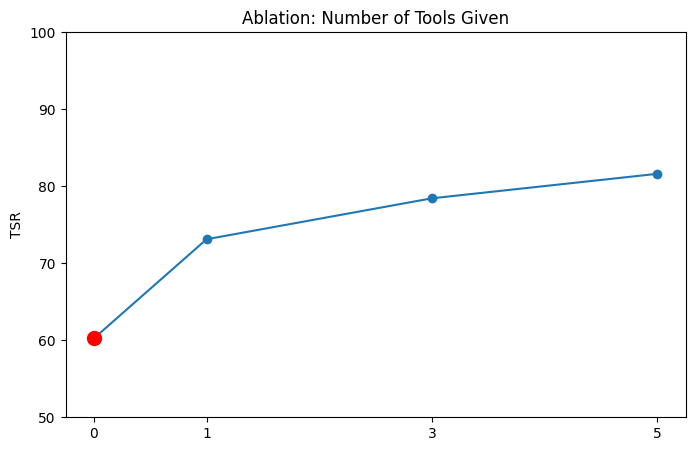

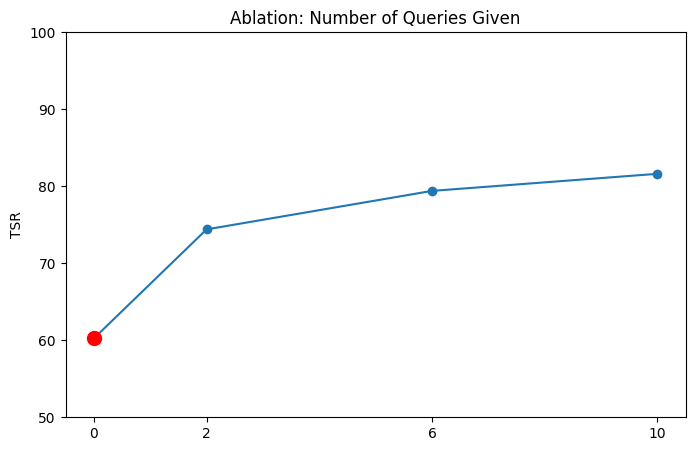

           model      setting  attack_success_rate  num_feedback_tools  \
0  deepseek-chat     original                81.62                   5   
1  deepseek-chat     one-tool                73.12                   1   
2  deepseek-chat   three-tool                78.44                   3   
3  deepseek-chat  six-queries                79.40                   5   
4  deepseek-chat  two-queries                74.40                   5   
5  deepseek-chat      no-info                60.24                   0   

   num_feedback_queries  
0                    10  
1                    10  
2                    10  
3                     6  
4                     2  
5                     0  


In [22]:
abl_df = []

original_percentages = get_best_percentage(f"final-results/deepseek-chat/attack")
args = get_dir_info(f"final-results/deepseek-chat/attack")
original_attack_success_rate = np.mean(original_percentages)
num_feedback_tools = args.get('num_feedback_tools', 5)
num_feedback_queries = args.get('num_feedback_queries', 10)
abl_df.append({'model': "deepseek-chat", 'setting': "original", 'attack_success_rate': original_attack_success_rate, 'num_feedback_tools': num_feedback_tools, 'num_feedback_queries': num_feedback_queries})


ablations_dir = "final-results/deepseek-chat/ablations"
for ablation in os.listdir(ablations_dir):
    # read all *-improvement-history.jsonl files in the model directory
    percentages = get_best_percentage(f"final-results/deepseek-chat/ablations/{ablation}")
    if not percentages:
        continue
    attack_success_rate = np.mean(percentages)

    # read args file and get num_feedback_tools, and num_feedback_queries
    args = get_dir_info(f"final-results/deepseek-chat/ablations/{ablation}")
    num_feedback_tools = args.get('num_feedback_tools')
    if num_feedback_tools is None:
        num_feedback_tools = 5
    num_feedback_queries = args.get('num_feedback_queries')
    if num_feedback_queries is None:
        num_feedback_queries = 10
    abl_df.append({'model': "deepseek-chat", 'setting': ablation, 'attack_success_rate': attack_success_rate, 'num_feedback_tools': num_feedback_tools, 'num_feedback_queries': num_feedback_queries})


# Convert abl_df to DataFrame
abl_df = pd.DataFrame(abl_df)

# First plot: 'original', any settings ending in '-tool', and 'no-info'
plot1_settings = ['no-info'] + [s for s in abl_df['setting'] if s.endswith('-tool')] + ['original']
plot1_df = abl_df[abl_df['setting'].isin(plot1_settings)].copy()
plot1_df = plot1_df.sort_values('num_feedback_tools')

plt.figure(figsize=(8, 5))
plt.plot(plot1_df['num_feedback_tools'], plot1_df['attack_success_rate'], marker='o')
plt.ylabel('TSR')
plt.ylim(50, 100)
plt.title("Ablation: Number of Tools Given")
plt.xticks(plot1_df['num_feedback_tools'])

line = plt.gca().lines[0]
xdata = line.get_xdata()
ydata = line.get_ydata()
if len(xdata) > 0:
    plt.scatter([xdata[0]], [ydata[0]], color='red', zorder=5, s=100)


plt.show()

# Second plot: 'original', any settings ending in '-tool', then 'no-info'
plot2_settings = ['no-info'] + [s for s in abl_df['setting'] if s.endswith('-queries')] + ['original']

plot2_df = abl_df[abl_df['setting'].isin(plot2_settings)].copy()
plot2_df = plot2_df.sort_values('num_feedback_queries') 


plt.figure(figsize=(8, 5))
plt.plot(plot2_df['num_feedback_queries'], plot2_df['attack_success_rate'], marker='o')
plt.ylabel('TSR')
plt.ylim(50, 100)
plt.xticks(plot2_df['num_feedback_queries'])

# Color the first dot red
line = plt.gca().lines[0]
xdata = line.get_xdata()
ydata = line.get_ydata()
if len(xdata) > 0:
    plt.scatter([xdata[0]], [ydata[0]], color='red', zorder=5, s=100)

plt.title("Ablation: Number of Queries Given")
plt.show()

print(abl_df)

In [24]:
# Average Attack Success Rate per iteration
iteration_df = []
for model in models:
    for i in range(1, 11):
        percentages = get_best_percentage(f"final-results/{model}/attack", iterations=i)
        if not percentages:
            continue
        attack_success_rate = np.mean(percentages)
        iteration_df.append({'model': model, 'iteration': i, 'attack_success_rate': attack_success_rate})

iteration_df = pd.DataFrame(iteration_df)
iteration_df.pivot(index='iteration', columns='model', values='attack_success_rate')

model,deepseek-chat,gemini-2.5-flash-lite,gpt-oss,grok-3-mini,llama3.1,qwen2.5
iteration,,,,,,
1,20.16,18.86,18.96,19.94,19.84,19.90
2,60.66,34.94,60.54,35.60,25.06,37.12
3,68.04,38.04,65.02,41.66,29.06,41.90
4,71.60,41.02,66.24,43.32,30.00,43.46
5,75.02,41.88,69.00,44.78,30.76,44.22
6,76.12,43.92,70.66,46.98,31.84,44.66
7,77.64,45.92,72.00,47.86,32.52,45.00
8,79.80,47.04,72.52,49.34,33.04,45.38
9,81.52,47.92,73.50,50.24,33.76,45.76


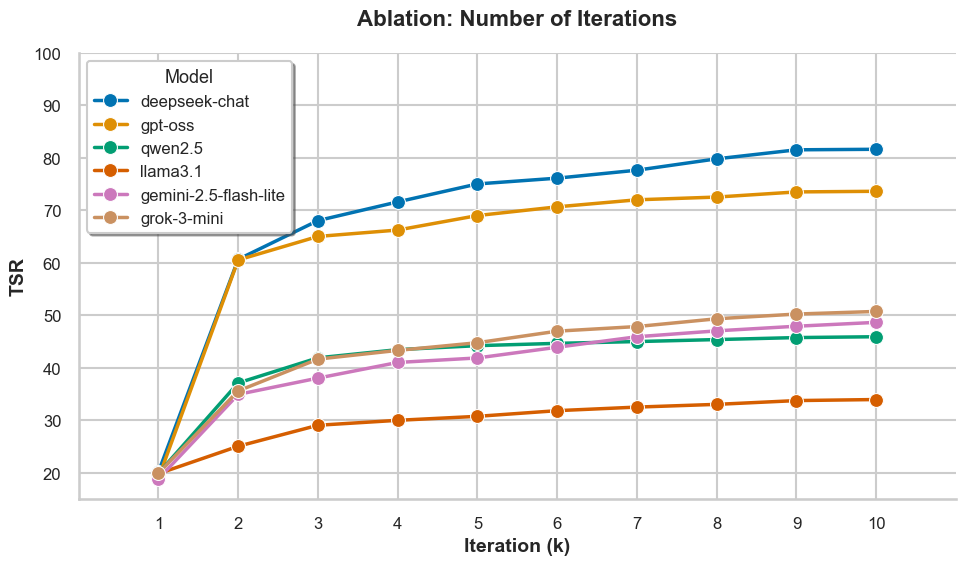

In [25]:
# plot attack success rate per iteration for each model using seaborn, with a fancier look

import seaborn as sns

sns.set_theme(style="whitegrid", context="talk", palette="colorblind")

plt.figure(figsize=(10, 6))
ax = sns.lineplot(
    data=iteration_df,
    x='iteration',
    y='attack_success_rate',
    hue='model',
    marker='o',
    linewidth=2.5,
    markersize=10,
)

plt.xlabel('Iteration (k)', fontsize=14, fontweight='bold')
plt.ylabel('TSR', fontsize=14, fontweight='bold')
plt.title('Ablation: Number of Iterations', fontsize=16, fontweight='bold', pad=20)
plt.xticks(range(1, 11), fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(15, 100)
plt.xlim(0, 11)
plt.legend(title='Model', fontsize=12, title_fontsize=13, loc='upper left', frameon=True, fancybox=True, shadow=True)
sns.despine()
plt.tight_layout()
plt.show()
